# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [2]:
batch_size_train = 64
batch_size_test = 1000

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

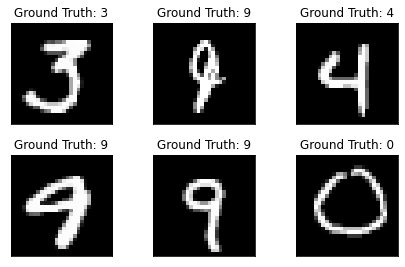

In [5]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [8]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [9]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [10]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
! mkdir -p results

In [12]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [13]:
train(1)

/tmp/ipykernel_171/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784094
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237687
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (

<br />
Alongside training, we will also monitor the performance of the model on a set of samples not seen during the training.

In [14]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [15]:
test()

/tmp/ipykernel_171/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/opt/conda/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [16]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch)
  test()

/tmp/ipykernel_171/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488056
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586397
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554512
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585009
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (

# Model performance

Finally, we can inspect the results.

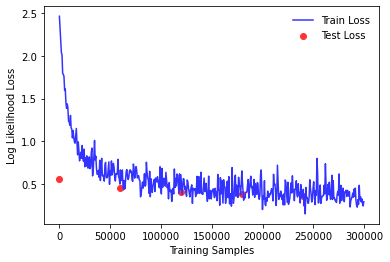

In [17]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [18]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

/tmp/ipykernel_171/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge:** Can you explain why we are using `torch.no_grad()`?

**Answer:** We are using `torch.no_grad()` in this example because we don't need the gradients or to change the weights already learned. Therefore, we use `torch.no_grad()` to run the model on the 1000 examples from example_data with the network trained as is, while saving computations and memory space.

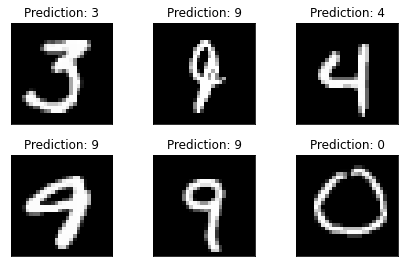

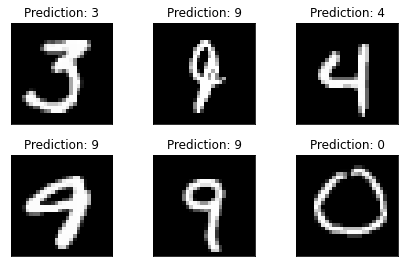

In [19]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

In [20]:
mis_class = []
for i in range(1000):
    prediction = output.data.max(1, keepdim=True)[1][i].item()
    ground_truth = example_targets[i].item()
    if prediction != ground_truth:
        mis_class.append(i)
    if len(mis_class) == 6:
        break
mis_class

[12, 18, 37, 38, 41, 48]

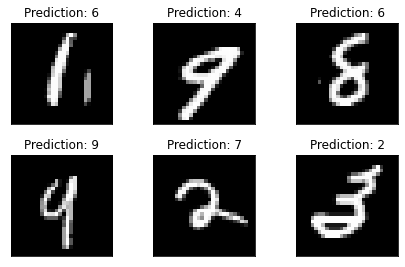

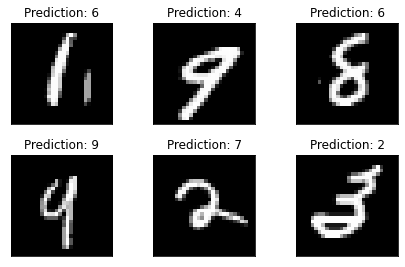

In [21]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[mis_class[i]][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][mis_class[i]].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Answer:** Above is my plot for 6 of the model's misclassifications. Visually it can be seen that all are different numbers than the model predicted, but some, like the 1 that is predicted 6 and the 4 that is predicted 9, are very close to looking like the number the model predicted. The model makes mistakes on oddly written numbers, but otherwise does a great job.

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [22]:
! ls results

model_iteration-1.pth  model_iteration-5.pth	  optimizer_iteration-4.pth
model_iteration-2.pth  optimizer_iteration-1.pth  optimizer_iteration-5.pth
model_iteration-3.pth  optimizer_iteration-2.pth
model_iteration-4.pth  optimizer_iteration-3.pth


To load a model:

In [23]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [24]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [25]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

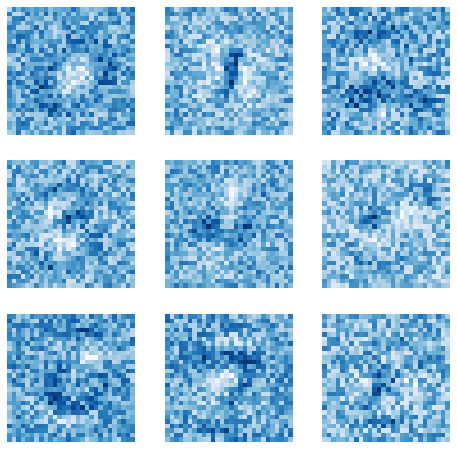

In [26]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [27]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [28]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

In [29]:
optimizer_state_dict

{'state': {0: {'momentum_buffer': tensor([[-1.3096e-03, -1.3096e-03, -1.3096e-03,  ..., -1.3096e-03,
            -1.3096e-03, -1.3096e-03],
           [ 9.4564e-05,  9.4564e-05,  9.4564e-05,  ...,  9.4564e-05,
             9.4564e-05,  9.4564e-05],
           [ 7.4225e-03,  7.4225e-03,  7.4225e-03,  ...,  7.4225e-03,
             7.4225e-03,  7.4225e-03],
           ...,
           [-3.4549e-04, -3.4549e-04, -3.4549e-04,  ..., -3.4549e-04,
            -3.4549e-04, -3.4549e-04],
           [ 5.1118e-03,  5.1118e-03,  5.1118e-03,  ...,  5.1118e-03,
             5.1118e-03,  5.1118e-03],
           [-4.0428e-03, -4.0428e-03, -4.0428e-03,  ..., -4.0428e-03,
            -4.0428e-03, -4.0428e-03]])},
  1: {'momentum_buffer': tensor([ 3.0871e-03, -2.2291e-04, -1.7497e-02, -1.0883e-02,  1.6721e-02,
            3.4197e-05,  1.0465e-02,  8.1442e-04, -1.2050e-02,  9.5301e-03])}},
 'param_groups': [{'lr': 0.001,
   'momentum': 0.1,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   

In [30]:
optimizer_state_dict['state'][0]['momentum_buffer'].size()

torch.Size([10, 784])

In [31]:
optimizer_state_dict['state'][1]['momentum_buffer']

tensor([ 3.0871e-03, -2.2291e-04, -1.7497e-02, -1.0883e-02,  1.6721e-02,
         3.4197e-05,  1.0465e-02,  8.1442e-04, -1.2050e-02,  9.5301e-03])

**Challenge:** Can you make sense of the data in this dictionary?

**Answer:** The optimizer state dict contains the learned weight and bias terms for the neural network. State 0 holds a tensor of size 10x784, containing weights for each of the ten digits across the 784 pixels of the image. State 1 holds a tensor of 1x10, holding the bias terms for the output layer for each of the ten digits.

## Final challenges

* What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* What happens if you change parameters like the learning rate and momentum? Plot the difference.
* Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* [stretch] Can you change this model and turn it into a convolutional neural network?

#### Question 1: Using 10% of training data

In [20]:
import random
full_dataset = torchvision.datasets.MNIST(
    './files/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

full_len = len(full_dataset)
new_size = int(full_len * 0.1)
new_idx = random.sample(range(full_len), new_size)

subset10pct = torch.utils.data.Subset(full_dataset, new_idx)

train10pct_loader = torch.utils.data.DataLoader(subset10pct, batch_size=batch_size_train, shuffle=True)

In [21]:
network10pct = FeedforwardNeuralNetModel()
optimizer10pct = optim.SGD(network10pct.parameters(), lr=learning_rate, momentum=momentum)
train_losses10pct = []
train_counter10pct = []
test_losses10pct = []
test_counter10pct = [i*len(train10pct_loader.dataset) for i in range(n_epochs + 1)]

In [22]:
def train10pct(epoch):
    network10pct.train()
    for batch_idx, (data, target) in enumerate(train10pct_loader):
        optimizer10pct.zero_grad() # clears gradients
        output = network10pct(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer10pct.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train10pct_loader.dataset),
                100. * batch_idx / len(train10pct_loader), loss.item())
            )
            train_losses10pct.append(loss.item())
            train_counter10pct.append((batch_idx*64) + ((epoch-1)*len(train10pct_loader.dataset)))
            torch.save(network10pct.state_dict(), f'./results/model10pct_iteration-{epoch}.pth')
            torch.save(optimizer10pct.state_dict(), f'./results/optimizer10pct_iteration-{epoch}.pth')
            
def test10pct():
    network10pct.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network10pct(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses10pct.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [23]:
for epoch in range(1, n_epochs + 1):
    train10pct(epoch)
    test10pct()

/tmp/ipykernel_171/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.644009
Train Epoch: 1 [640/6000 (11%)]	Loss: 2.347366
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.107368
Train Epoch: 1 [1920/6000 (32%)]	Loss: 2.093294
Train Epoch: 1 [2560/6000 (43%)]	Loss: 1.898182
Train Epoch: 1 [3200/6000 (53%)]	Loss: 1.884448
Train Epoch: 1 [3840/6000 (64%)]	Loss: 1.840793
Train Epoch: 1 [4480/6000 (74%)]	Loss: 1.766941
Train Epoch: 1 [5120/6000 (85%)]	Loss: 1.703903
Train Epoch: 1 [5760/6000 (96%)]	Loss: 1.647305


/opt/conda/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.5747, Accuracy: 5972/10000 (60%)

Train Epoch: 2 [0/6000 (0%)]	Loss: 1.659789
Train Epoch: 2 [640/6000 (11%)]	Loss: 1.689028
Train Epoch: 2 [1280/6000 (21%)]	Loss: 1.426357
Train Epoch: 2 [1920/6000 (32%)]	Loss: 1.377600
Train Epoch: 2 [2560/6000 (43%)]	Loss: 1.409826
Train Epoch: 2 [3200/6000 (53%)]	Loss: 1.358664
Train Epoch: 2 [3840/6000 (64%)]	Loss: 1.230207
Train Epoch: 2 [4480/6000 (74%)]	Loss: 1.185295
Train Epoch: 2 [5120/6000 (85%)]	Loss: 1.184184
Train Epoch: 2 [5760/6000 (96%)]	Loss: 1.135879

Test set: Avg. loss: 1.1724, Accuracy: 7384/10000 (74%)

Train Epoch: 3 [0/6000 (0%)]	Loss: 1.137966
Train Epoch: 3 [640/6000 (11%)]	Loss: 1.020595
Train Epoch: 3 [1280/6000 (21%)]	Loss: 1.298936
Train Epoch: 3 [1920/6000 (32%)]	Loss: 1.088345
Train Epoch: 3 [2560/6000 (43%)]	Loss: 1.085127
Train Epoch: 3 [3200/6000 (53%)]	Loss: 1.043087
Train Epoch: 3 [3840/6000 (64%)]	Loss: 0.979318
Train Epoch: 3 [4480/6000 (74%)]	Loss: 1.062223
Train Epoch: 3 [5120/6000 (85%

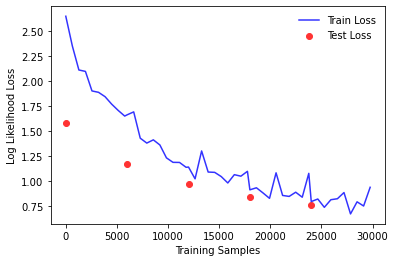

In [24]:
fig = pl.figure()
pl.plot(train_counter10pct, train_losses10pct, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter10pct[:-1], test_losses10pct, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

Obviously, if 10% of the training data is used, then the model will not be as accurate and both the train and test loss will be higher. In this case, the difference was drastic. Loss never got below 0.75, as opposed to 0.36 in the original model, and accuracy only reached 83% as opposed to 90%. More training epochs would likely increase the accuracy of the model, even with 10% of the training data, but at some point the model will discover all the patterns it can from its limited training set, and will likely not reach the accuracy of the original model.

#### Question 2: Removing 80% of 5's

In [11]:
train_loader5 = torchvision.datasets.MNIST('./files/', train=True, download=True,
                                        transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                        ]))
data = train_loader5.data
targets = train_loader5.targets

indices_of_fives = (targets == 5).nonzero(as_tuple=True)[0]

num_fives_to_drop = int(0.80 * len(indices_of_fives))
dropped_fives_indices = indices_of_fives[torch.randperm(len(indices_of_fives))[:num_fives_to_drop]]

mask = torch.ones(len(targets), dtype=bool)
mask[dropped_fives_indices] = False

filtered_data = data[mask]
filtered_targets = targets[mask]

filtered_dataset = torch.utils.data.TensorDataset(filtered_data, filtered_targets)

train_loader5 = torch.utils.data.DataLoader(filtered_dataset, batch_size=batch_size_train, shuffle=True)

In [12]:
network_no5 = FeedforwardNeuralNetModel()
optimizer_no5 = optim.SGD(network_no5.parameters(), lr=learning_rate, momentum=momentum)
train_losses_no5 = []
train_counter_no5 = []
test_losses_no5 = []
test_counter_no5 = [i*len(train_loader5.dataset) for i in range(n_epochs + 1)]

In [13]:
def train_no5(epoch):
    network_no5.train()
    for batch_idx, (data, target) in enumerate(train_loader5):
        optimizer_no5.zero_grad() # clears gradients
        data = data.float()
        output = network_no5(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer_no5.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader5.dataset),
                100. * batch_idx / len(train_loader5), loss.item())
            )
            train_losses_no5.append(loss.item())
            train_counter_no5.append((batch_idx*64) + ((epoch-1)*len(train_loader5.dataset)))
            torch.save(network_no5.state_dict(), f'./results/model_no5_iteration-{epoch}.pth')
            torch.save(optimizer_no5.state_dict(), f'./results/optimizer_no5_iteration-{epoch}.pth')
            
def test_no5():
    network_no5.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_no5(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_no5.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [14]:
for epoch in range(1, n_epochs + 1):
    train_no5(epoch)
    test_no5()

/tmp/ipykernel_161/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/55664 (0%)]	Loss: 84.666862
Train Epoch: 1 [640/55664 (1%)]	Loss: 57.769096
Train Epoch: 1 [1280/55664 (2%)]	Loss: 21.375151
Train Epoch: 1 [1920/55664 (3%)]	Loss: 19.733250
Train Epoch: 1 [2560/55664 (5%)]	Loss: 20.960464
Train Epoch: 1 [3200/55664 (6%)]	Loss: 29.752693
Train Epoch: 1 [3840/55664 (7%)]	Loss: 7.599046
Train Epoch: 1 [4480/55664 (8%)]	Loss: 8.020789
Train Epoch: 1 [5120/55664 (9%)]	Loss: 13.533997
Train Epoch: 1 [5760/55664 (10%)]	Loss: 20.357029
Train Epoch: 1 [6400/55664 (11%)]	Loss: 34.177933
Train Epoch: 1 [7040/55664 (13%)]	Loss: 26.268759
Train Epoch: 1 [7680/55664 (14%)]	Loss: 6.228716
Train Epoch: 1 [8320/55664 (15%)]	Loss: 34.453655
Train Epoch: 1 [8960/55664 (16%)]	Loss: 33.229237
Train Epoch: 1 [9600/55664 (17%)]	Loss: 7.981556
Train Epoch: 1 [10240/55664 (18%)]	Loss: 7.077550
Train Epoch: 1 [10880/55664 (20%)]	Loss: 10.892690
Train Epoch: 1 [11520/55664 (21%)]	Loss: 23.887524
Train Epoch: 1 [12160/55664 (22%)]	Loss: 28.988123
Train Epoch: 1

/opt/conda/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4600, Accuracy: 8621/10000 (86%)

Train Epoch: 2 [0/55664 (0%)]	Loss: 21.910418
Train Epoch: 2 [640/55664 (1%)]	Loss: 28.709709
Train Epoch: 2 [1280/55664 (2%)]	Loss: 13.501217
Train Epoch: 2 [1920/55664 (3%)]	Loss: 18.664879
Train Epoch: 2 [2560/55664 (5%)]	Loss: 22.363306
Train Epoch: 2 [3200/55664 (6%)]	Loss: 11.579639
Train Epoch: 2 [3840/55664 (7%)]	Loss: 8.373224
Train Epoch: 2 [4480/55664 (8%)]	Loss: 18.127974
Train Epoch: 2 [5120/55664 (9%)]	Loss: 8.655657
Train Epoch: 2 [5760/55664 (10%)]	Loss: 21.657169
Train Epoch: 2 [6400/55664 (11%)]	Loss: 11.769963
Train Epoch: 2 [7040/55664 (13%)]	Loss: 2.581941
Train Epoch: 2 [7680/55664 (14%)]	Loss: 25.197454
Train Epoch: 2 [8320/55664 (15%)]	Loss: 7.433450
Train Epoch: 2 [8960/55664 (16%)]	Loss: 11.212578
Train Epoch: 2 [9600/55664 (17%)]	Loss: 18.266287
Train Epoch: 2 [10240/55664 (18%)]	Loss: 15.700808
Train Epoch: 2 [10880/55664 (20%)]	Loss: 13.157972
Train Epoch: 2 [11520/55664 (21%)]	Loss: 4.286109
Train E

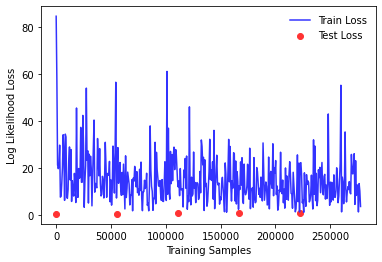

In [15]:
fig = pl.figure()
pl.plot(train_counter_no5, train_losses_no5, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_no5[:-1], test_losses_no5, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's very likely that my code did something wrong, because I don't think a lack of 5's in the training set would cause this big of an issue in training the model. However, I would expect that taking out 80% of the images with label 5 from the training set would reduce the accuracy of the model, especially for identifying 5's. The model should be able to identify the other digits at around the same accuracy, but it would be significantly reduced for 5's.

#### Question 3: Change learning rate and momentum

In [11]:
network_lr_m = FeedforwardNeuralNetModel()
optimizer_lr_m = optim.SGD(network_lr_m.parameters(), lr=0.005, momentum=1)

In [12]:
train_losses_lr_m = []
train_counter_lr_m = []
test_losses_lr_m = []
test_counter_lr_m = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [13]:
def train_lr_m(epoch):
    network_lr_m.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_lr_m.zero_grad() # clears gradients
        output = network_lr_m(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer_lr_m.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_lr_m.append(loss.item())
            train_counter_lr_m.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network_lr_m.state_dict(), f'./results/model_lr_m_iteration-{epoch}.pth')
            torch.save(optimizer_lr_m.state_dict(), f'./results/optimizer_lr_m_iteration-{epoch}.pth')

def test_lr_m():
    network_lr_m.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_lr_m(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_lr_m.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [14]:
for epoch in range(1, n_epochs + 1):
  train_lr_m(epoch)
  test_lr_m()

/tmp/ipykernel_161/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.454058
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.943345
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.443907
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.715086
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.781642
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.465124
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.523350
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.291279
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.407206
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.055223
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.666568
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.638798
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.183351
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.344126
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.389663
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.711532
Train Epoch: 1 [10240/60000 (17%)]	Loss: 3.248347
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.293932
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.879900
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.034604
Train Epoch: 1 [12800/60000 (

/opt/conda/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 5.2294, Accuracy: 8725/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 5.633784
Train Epoch: 2 [640/60000 (1%)]	Loss: 4.515209
Train Epoch: 2 [1280/60000 (2%)]	Loss: 1.365696
Train Epoch: 2 [1920/60000 (3%)]	Loss: 4.821358
Train Epoch: 2 [2560/60000 (4%)]	Loss: 3.962518
Train Epoch: 2 [3200/60000 (5%)]	Loss: 4.478636
Train Epoch: 2 [3840/60000 (6%)]	Loss: 2.719066
Train Epoch: 2 [4480/60000 (7%)]	Loss: 14.119017
Train Epoch: 2 [5120/60000 (9%)]	Loss: 6.620938
Train Epoch: 2 [5760/60000 (10%)]	Loss: 6.001591
Train Epoch: 2 [6400/60000 (11%)]	Loss: 5.843095
Train Epoch: 2 [7040/60000 (12%)]	Loss: 1.371390
Train Epoch: 2 [7680/60000 (13%)]	Loss: 5.928409
Train Epoch: 2 [8320/60000 (14%)]	Loss: 1.946942
Train Epoch: 2 [8960/60000 (15%)]	Loss: 2.992218
Train Epoch: 2 [9600/60000 (16%)]	Loss: 6.715946
Train Epoch: 2 [10240/60000 (17%)]	Loss: 5.750470
Train Epoch: 2 [10880/60000 (18%)]	Loss: 3.373306
Train Epoch: 2 [11520/60000 (19%)]	Loss: 6.659477
Train Epoch: 2 [1216

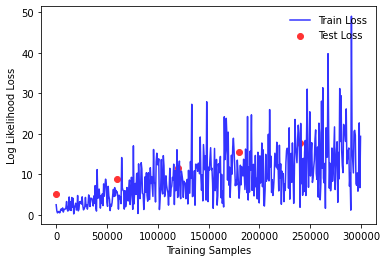

In [15]:
fig = pl.figure()
pl.plot(train_counter_lr_m, train_losses_lr_m, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_lr_m[:-1], test_losses_lr_m, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

With the higher learning rate and momentum, the model very quickly found reduced loss, but both were clearly too high, as both the train and test loss increased with more epochs. The global minimum was passed, then the model climbed out of it, failing to optimize the model. Next, I will try a smaller learning rate and momentum than the original.

In [16]:
network_lr_m2 = FeedforwardNeuralNetModel()
optimizer_lr_m2 = optim.SGD(network_lr_m2.parameters(), lr=0.0005, momentum=0.01)

train_losses_lr_m2 = []
train_counter_lr_m2 = []
test_losses_lr_m2 = []
test_counter_lr_m2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train_lr_m2(epoch):
    network_lr_m2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_lr_m2.zero_grad() # clears gradients
        output = network_lr_m2(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer_lr_m2.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_lr_m2.append(loss.item())
            train_counter_lr_m2.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network_lr_m2.state_dict(), f'./results/model_lr_m2_iteration-{epoch}.pth')
            torch.save(optimizer_lr_m2.state_dict(), f'./results/optimizer_lr_m2_iteration-{epoch}.pth')

def test_lr_m2():
    network_lr_m2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_lr_m2(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_lr_m2.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [17]:
for epoch in range(1, n_epochs + 1):
  train_lr_m2(epoch)
  test_lr_m2()

/tmp/ipykernel_161/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.341127
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.270695
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.179317
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.193749
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.156569
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.073053
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.024552
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.035628
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.880359
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.816752
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.807598
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.750362
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.903359
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.751689
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.744853
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.662117
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.636384
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.592537
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.621564
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.620431
Train Epoch: 1 [12800/60000 (

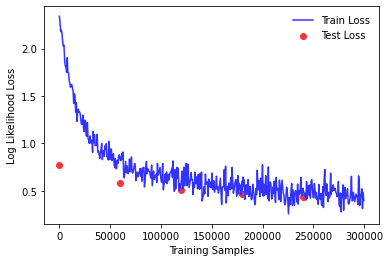

In [18]:
fig = pl.figure()
pl.plot(train_counter_lr_m2, train_losses_lr_m2, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_lr_m2[:-1], test_losses_lr_m2, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

With lower learning rate and momentum, the model was still able to converge towards a global minimum, but at a slower rate. As a result, this model is slightly less accurate than the orginial one after 5 epochs of training. It can achieve more accuracy with more epochs. Also, the smaller learning rate and momentum cause variation of loss over each training sample is lower than the original (as seen in the plot above).

#### Question 4: Adding hidden layer

In [21]:
# add layer and run train/test code
class FeedforwardNeuralNetModelHiddenLayer(nn.Module):
    def __init__(self):
        input_dim = 28*28
        hidden_dim = 128
        num_classes = 10
        super(FeedforwardNeuralNetModelHiddenLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        out = self.fc2(x)
        return F.log_softmax(out)

Above, I added in a new hidden layer with 128 dimensions and a relu activation

In [22]:
network_hl = FeedforwardNeuralNetModelHiddenLayer()
optimizer_hl = optim.SGD(network_hl.parameters(), lr=learning_rate, momentum=momentum)

train_losses_hl = []
train_counter_hl = []
test_losses_hl = []
test_counter_hl = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train_hl(epoch):
    network_hl.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_hl.zero_grad() # clears gradients
        output = network_hl(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer_hl.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_hl.append(loss.item())
            train_counter_hl.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network_hl.state_dict(), f'./results/model_hl_iteration-{epoch}.pth')
            torch.save(optimizer_hl.state_dict(), f'./results/optimizer_hl_iteration-{epoch}.pth')

def test_hl():
    network_hl.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_hl(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_hl.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [23]:
for epoch in range(1, n_epochs + 1):
  train_hl(epoch)
  test_hl()

/tmp/ipykernel_161/1961788797.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298167
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.278112
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.276498
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.273858
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.229511
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.252434
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.226070
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.182453
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.157757
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.140598
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.171793
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.086569
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.137123
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.091904
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.055201
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.014942
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.027552
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.996256
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.985890
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.924158
Train Epoch: 1 [12800/60000 (

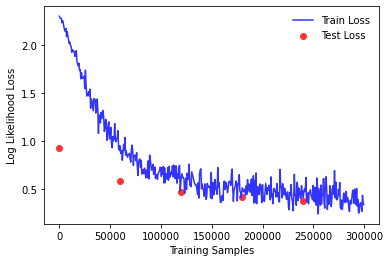

In [24]:
fig = pl.figure()
pl.plot(train_counter_hl, train_losses_hl, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_hl[:-1], test_losses_hl, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

I noticed 2 changes from running the NN with a hidden layer. The first was that the training took much longer. This makes sense, as the new layer added complexity and more computations. The second, as seen in the chart, is the loss took longer to dininish at the beginning than the other models. After 50000 training samples, loss remained over 1.0, while in previous models it was already down to around 0.75. Also, it is worth noting that this model did not perform better than the model without a hidden layer. The final accuracy was around 90% for both.

#### Question 5: L1, L2, Dropout Regularization

In [28]:
#L1
l1_lambda = 0.001

network_l1 = FeedforwardNeuralNetModel()
optimizer_l1 = optim.SGD(network_l1.parameters(), lr=learning_rate, momentum=momentum)

train_losses_l1 = []
train_counter_l1 = []
test_losses_l1 = []
test_counter_l1 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train_l1(epoch):
    network_l1.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_l1.zero_grad() # clears gradients
        output = network_l1(data.reshape(-1, 28*28))
        
        l1_loss = sum(param.abs().sum() for param in network_l1.parameters()) # compute L1 loss
        loss = F.nll_loss(output, target) + l1_lambda * l1_loss # add L1 loss to original loss
        loss.backward()
        
        optimizer_l1.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_l1.append(loss.item())
            train_counter_l1.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network_l1.state_dict(), f'./results/model_l1_iteration-{epoch}.pth')
            torch.save(optimizer_l1.state_dict(), f'./results/optimizer_l1_iteration-{epoch}.pth')

def test_l1():
    network_l1.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_l1(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [29]:
for epoch in range(1, n_epochs + 1):
  train_l1(epoch)
  test_l1()

/tmp/ipykernel_161/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.498293
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.323304
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.079000
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.191809
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.001750
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.854718
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.885588
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.714579
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.737522
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.682166
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.617802
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.551967
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.544184
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.557102
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.502828
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.241065
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.374947
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.297364
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.296858
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.158887
Train Epoch: 1 [12800/60000 (

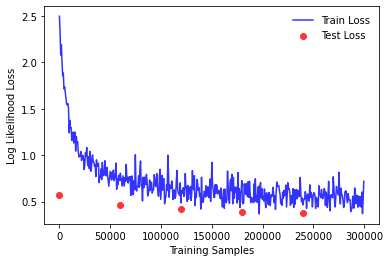

In [30]:
fig = pl.figure()
pl.plot(train_counter_l1, train_losses_l1, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_l1[:-1], test_losses_l1, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

Regularization is used to ensure the training doesn't overfit the model on the training data. As seen in the chart above, the L1 regularization causes the train loss to increase across the board, getting separation from the test data. For this example, L1 regularization wasn't necessary as the train and test loss remained close, and overfitting was not an issue. However, the difference caused by L1 regularization is still seen here.

In [11]:
#L2 - added automatically through the optimizer in pytorch with weight_decay
network_l2 = FeedforwardNeuralNetModel()
optimizer_l2 = optim.SGD(network_l2.parameters(), lr=learning_rate, momentum=momentum, weight_decay = 0.01) #L2 regularization

train_losses_l2 = []
train_counter_l2 = []
test_losses_l2 = []
test_counter_l2 = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train_l2(epoch):
    network_l2.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_l2.zero_grad() # clears gradients
        output = network_l2(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer_l2.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_l2.append(loss.item())
            train_counter_l2.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network_l2.state_dict(), f'./results/model_l2_iteration-{epoch}.pth')
            torch.save(optimizer_l2.state_dict(), f'./results/optimizer_l2_iteration-{epoch}.pth')

def test_l2():
    network_l2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_l2(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_l2.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [12]:
for epoch in range(1, n_epochs + 1):
  train_l2(epoch)
  test_l2()

/tmp/ipykernel_160/3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.454058
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.275439
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.201468
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.023104
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.870271
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.808135
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.874287
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.755790
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.614905
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.561840
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.549785
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.474228
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.508482
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.374738
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.365511
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.365639
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.470280
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.269719
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.125219
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.194162
Train Epoch: 1 [12800/60000 (

/opt/conda/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5683, Accuracy: 8673/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.596155
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.599441
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.502119
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.568500
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.537249
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.611313
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.420760
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.831409
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.535163
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.573186
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.607499
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.418797
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.543603
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.438548
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.559929
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.707880
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.549522
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.499250
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.695677
Train Epoch: 2 [12160

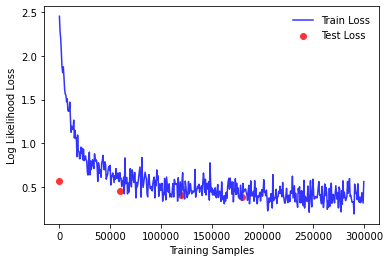

In [13]:
fig = pl.figure()
pl.plot(train_counter_l2, train_losses_l2, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_l2[:-1], test_losses_l2, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

Unlike L1 regularization, there isn't a difference seen between train and test loss for L2 regularization. Perhaps the weight_decay value I used for this model was too small, so the regularization did not have as much of an effect.

In [14]:
# Dropout - regularization added by dropping out a percentage of inputs in model
class FeedforwardNeuralNetModelDropout(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModelDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 
        self.dropout = nn.Dropout(p=0.2) # Drop out 20%

    def forward(self, x):
        x = self.fc1(x)
        out = self.dropout(x)
        return F.log_softmax(out)

In [15]:
network_drop = FeedforwardNeuralNetModelDropout()
optimizer_drop = optim.SGD(network_drop.parameters(), lr=learning_rate, momentum=momentum)

train_losses_drop = []
train_counter_drop = []
test_losses_drop = []
test_counter_drop = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train_drop(epoch):
    network_drop.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_drop.zero_grad() # clears gradients
        output = network_drop(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer_drop.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_drop.append(loss.item())
            train_counter_drop.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network_drop.state_dict(), f'./results/model_drop_iteration-{epoch}.pth')
            torch.save(optimizer_drop.state_dict(), f'./results/optimizer_drop_iteration-{epoch}.pth')

def test_drop():
    network_drop.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_drop(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_drop.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [16]:
for epoch in range(1, n_epochs + 1):
  train_drop(epoch)
  test_drop()

/tmp/ipykernel_160/4097492116.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.366124
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.215546
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.068638
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.048033
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.962678
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.882050
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.813306
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.761022
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.646051
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.567051
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.502523
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.485250
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.686284
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.449075
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.525234
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.384674
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.344135
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.308532
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.414773
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.373645
Train Epoch: 1 [12800/60000 (

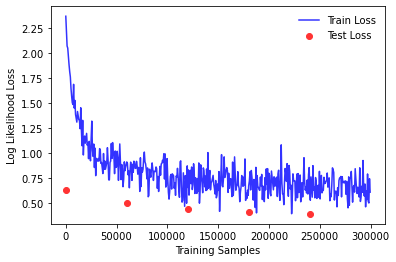

In [17]:
fig = pl.figure()
pl.plot(train_counter_drop, train_losses_drop, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_drop[:-1], test_losses_drop, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

Like L1 regularization, there is a difference seen here with the dropout regularization between the train and test loss. Also, the loss is more noisy here, which makes sense since a chunk of the training data was dropped out at random in the training process.

#### Question 6: CNN

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) # first convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # second convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer
        self.fc1 = nn.Linear(64 * 7 * 7, 128) # Fully connected layer: 64*7*7 input features, 128 output features
        self.fc2 = nn.Linear(128, 10) # Fully connected layer: 128 input features, 10 output classes (for MNIST digits)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [12]:
network_cnn = CNN()
optimizer_cnn = optim.SGD(network_cnn.parameters(), lr=learning_rate, momentum=momentum)

train_losses_cnn = []
train_counter_cnn = []
test_losses_cnn = []
test_counter_cnn = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train_cnn(epoch):
    network_cnn.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer_cnn.zero_grad() # clears gradients
        output = network_cnn(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer_cnn.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses_cnn.append(loss.item())
            train_counter_cnn.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network_cnn.state_dict(), f'./results/model_cnn_iteration-{epoch}.pth')
            torch.save(optimizer_cnn.state_dict(), f'./results/optimizer_cnn_iteration-{epoch}.pth')

def test_cnn():
    network_cnn.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network_cnn(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses_cnn.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [13]:
for epoch in range(1, n_epochs + 1):
  train_cnn(epoch)
  test_cnn()

/tmp/ipykernel_161/486621186.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.288374
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299441
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.287194
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299735
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.278541
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.265516
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.256008
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.268066
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.273497
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.257182
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.257616
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.267224
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.249255
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.250271
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.246841
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.254436
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.238223
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.236099
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.234556
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.233167
Train Epoch: 1 [12800/60000 (

/opt/conda/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.4689, Accuracy: 7448/10000 (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.572494
Train Epoch: 2 [640/60000 (1%)]	Loss: 1.397688
Train Epoch: 2 [1280/60000 (2%)]	Loss: 1.391890
Train Epoch: 2 [1920/60000 (3%)]	Loss: 1.423528
Train Epoch: 2 [2560/60000 (4%)]	Loss: 1.491876
Train Epoch: 2 [3200/60000 (5%)]	Loss: 1.387600
Train Epoch: 2 [3840/60000 (6%)]	Loss: 1.431669
Train Epoch: 2 [4480/60000 (7%)]	Loss: 1.355480
Train Epoch: 2 [5120/60000 (9%)]	Loss: 1.264733
Train Epoch: 2 [5760/60000 (10%)]	Loss: 1.149898
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.371373
Train Epoch: 2 [7040/60000 (12%)]	Loss: 1.277591
Train Epoch: 2 [7680/60000 (13%)]	Loss: 1.200579
Train Epoch: 2 [8320/60000 (14%)]	Loss: 1.266365
Train Epoch: 2 [8960/60000 (15%)]	Loss: 1.237682
Train Epoch: 2 [9600/60000 (16%)]	Loss: 1.156664
Train Epoch: 2 [10240/60000 (17%)]	Loss: 1.166669
Train Epoch: 2 [10880/60000 (18%)]	Loss: 1.097604
Train Epoch: 2 [11520/60000 (19%)]	Loss: 1.091781
Train Epoch: 2 [12160

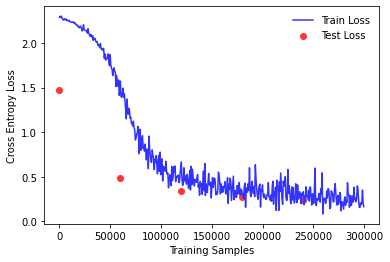

In [14]:
fig = pl.figure()
pl.plot(train_counter_cnn, train_losses_cnn, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter_cnn[:-1], test_losses_cnn, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Cross Entropy Loss')

pl.show()

Although it took longer to run (more complex NN, makes sense) and more training samples for the loss to decrease, the CNN achieved a greater accuracy than the basic feedforward network. CNNs are perfect for computer vision problems such as this, so it comes as no surprise that it performed better. 

Very cool!